## 00. 환경설정

In [1]:
import pandas as pd
import tensorflow as tf
import seaborn as sns
from datetime import datetime, date
import numpy as np
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
import xlearn as xl
K = tf.keras.backend

import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

## 01. Factorization Machine 구현
- Factorization Machine을 tensorflow 2.0으로 구현해봅니다.
- 주어진 무비렌즈 데이터를 tensorflow에 적합하게 가공하고 예측 모델을 학습합니다.
- 모델의 성능은 예측 성능인 RMSE로 평가합니다.

### 데이터 전처리

In [2]:
path = "../data/ml-100k/"

In [3]:
ratings_df = pd.read_csv(path + "u.data", sep="\t", encoding="latin-1", header=None)
ratings_df.columns = ['user_id', 'movie_id', 'rating', 'timestamp']
ratings_df.head()

,user_id,movie_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [4]:
movies_df  = pd.read_csv(path + "u.item", sep="|",  encoding="latin-1", header=None)
movies_df.columns = ['movie_id', 'movie_title', 'release_date', 'video_release_date',
                     'IMDb_URL', 'unknown', 'Action', 'Adventure', 'Animation', 
                     'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy',
                     'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi',
                     'Thriller', 'War', 'Western'] 
movies_df.head()

,movie_id,movie_title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Children,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [5]:
users_df   = pd.read_csv(path + "u.user", sep="|",  encoding="latin-1", header=None)
users_df.columns = ['user_id', 'age', 'gender', 'occupation', 'zip_code']
users_df.head()

,user_id,age,gender,occupation,zip_code
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537
4,5,33,F,other,15213


In [6]:
def age_map(x):
    if x < 20:
        return '10'
    elif x >= 20 and x < 30:
        return '20'
    elif x >= 30 and x < 40:
        return '30'
    elif x >= 40 and x < 50:
        return '40'
    elif x >= 50 and x < 60:
        return '50'
    else:
        return '60'

In [7]:
users_df['age'] = users_df['age'].apply(lambda x: age_map(x))

#### 유저 피쳐와 영화 피쳐를 FM에 사용하기 위해서 평점 dataframe에 JOIN 합니다.

In [8]:
fm_df = pd.merge(ratings_df, movies_df, how="left", on="movie_id")
fm_df = pd.merge(fm_df, users_df, how="left", on="user_id")
fm_df = fm_df[
    ['user_id', 'movie_id',
     'age', 'gender',
     'unknown', 'Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama',
     'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western',
     'rating']]
fm_df

,user_id,movie_id,age,gender,unknown,Action,Adventure,Animation,Children,Comedy,...,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,rating
0,196,242,40,M,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,3
1,186,302,30,F,0,0,0,0,0,0,...,1,0,0,1,0,0,1,0,0,3
2,22,377,20,M,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,1
3,244,51,20,M,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,1,2
4,166,346,40,M,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,880,476,10,M,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,3
99996,716,204,30,F,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,5
99997,276,1090,20,M,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
99998,13,225,40,M,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,2


#### 모든 피쳐를 categorical로 변환

In [9]:
fm_df['user_id']  = fm_df['user_id'].astype("category")
user_id_map = {value: idx for idx, value in enumerate(fm_df['user_id'].cat.categories)}
fm_df['user_id'] = fm_df['user_id'].cat.codes

In [10]:
fm_df['movie_id'] = fm_df['movie_id'].astype("category")
movie_id_map = {value: idx for idx, value in enumerate(fm_df['movie_id'].cat.categories)}
fm_df['movie_id'] = fm_df['movie_id'].cat.codes

In [11]:
fm_df['age'] = fm_df['age'].astype("category")
age_map = {value: idx for idx, value in enumerate(fm_df['age'].cat.categories)}
fm_df['age'] = fm_df['age'].cat.codes

In [12]:
fm_df['gender'] = fm_df['gender'].astype("category")
gender_map = {value: idx for idx, value in enumerate(fm_df['gender'].cat.categories)}
fm_df['gender'] = fm_df['gender'].cat.codes

In [13]:
genre_list = [
    'unknown', 'Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama',
    'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western'
]

In [14]:
age_map

{'10': 0, '20': 1, '30': 2, '40': 3, '50': 4, '60': 5}

In [15]:
fm_df

,user_id,movie_id,age,gender,unknown,Action,Adventure,Animation,Children,Comedy,...,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,rating
0,195,241,3,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,3
1,185,301,2,0,0,0,0,0,0,0,...,1,0,0,1,0,0,1,0,0,3
2,21,376,1,1,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,1
3,243,50,1,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,1,2
4,165,345,3,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,879,475,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,3
99996,715,203,2,0,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,5
99997,275,1089,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
99998,12,224,3,1,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,2


### FM 학습 데이터 생성

In [16]:
data = {"X" : [], 'y' : []}

# FM의 input variable 개수
size_X = len(user_id_map) + len(gender_map) + len(age_map) + len(movie_id_map) + len(genre_list)

for _, row in tqdm(fm_df.iterrows()):
    x = [0] * size_X
    
    # user variable
    idx = 0
    x[idx + row['user_id']] = 1
    idx += len(user_id_map)
    
    x[idx + row['gender']] = 1
    idx += len(gender_map)
    
    x[idx + row['age']] = 1
    idx += len(age_map)
    
    # movie variable
    x[idx + row['movie_id']] = 1
    idx += len(movie_id_map)
    
    # Genre - multi hot encoding
    x[idx : idx + len(genre_list)] = row[genre_list]
    
    data['X'].append(x)
    data['y'].append(row['rating'])
    
data['X'] = np.asarray(data['X'])
data['y'] = np.asarray(data['y'])

In [17]:
size_X

2652

In [18]:
data

{'X': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 1, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 1, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 1]]),
 'y': array([3, 3, 1, ..., 1, 2, 3], dtype=int64)}

#### 전체 데이터 개수

In [19]:
len(data['X'])

100000

#### input variable의 개수

In [20]:
len(data['X'][0])

2652

#### 전체 100,000개의 데이터를 train과 test로 나눔

In [21]:
X_train, X_test, y_train, y_test = train_test_split(data['X'], data['y'], test_size=0.2, random_state=10)

### Tensorflow로 FM 구현
![](https://i.ibb.co/6BfdMHd/fm.png)

In [22]:
class FMLayer(tf.keras.layers.Layer):
    def __init__(self, input_dim, factorization_dim=10, **kwargs):
        self.input_dim = input_dim
        self.factorization_dim = factorization_dim
        super(FMLayer, self).__init__(**kwargs)
        
    def build(self, input_shape):
        self.kernel = self.add_weight(name = 'fm_weight',
                                      shape=(input_shape[-1], self.factorization_dim),
                                      initializer='glorot_uniform',
                                      trainable=True)
        
        super(FMLayer, self).build(input_shape=input_shape)
        
    def call(self, x):
        a = K.pow(K.dot(x, self.kernel), 2)
        b = K.dot(K.pow(x, 2), K.pow(self.kernel, 2))
        return K.sum(a - b, 1, keepdims=True) * 0.5
    
    def compute_output_shape(self, input_shape):
        return (input_shape[0], 1)

In [23]:
def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

def FM(feature_dim, factorization_dim, task = 'reg'):
    inputs = tf.keras.Input((feature_dim,))
    linear = tf.keras.layers.Dense(units=1,
                                   kernel_initializer='glorot_uniform',
                                   bias_initializer='zeros',
                                   bias_regularizer=tf.keras.regularizers.l2(0.01),
                                   kernel_regularizer=tf.keras.regularizers.l1(0.01),
                                  )(inputs)
    cross = FMLayer(feature_dim, factorization_dim)(inputs)
    
    if task == 'reg':
        prediction = tf.keras.layers.Add()([linear, cross])
        model = tf.keras.Model(inputs=inputs, outputs=prediction)
        model.compile(loss=rmse,
                      optimizer=tf.keras.optimizers.Adam(0.001))
    
    elif task == 'binary':
        add = tf.keras.layers.Add()([linear, cross])
        prediction = tf.keras.layers.Activation('sigmoid')(add)
        model = tf.keras.Model(inputs=inputs, outputs=prediction)
        model.compile(loss='binary_crossentropy',
                      optimizer=tf.train.AdamOptimizer(0.001))
    
    return model

### FM 모델을 선언해줍니다.

In [24]:
factorization_dim = 20
fm = FM(size_X, factorization_dim, 'reg')
fm.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 2652)]       0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 1)            2653        input_1[0][0]                    
__________________________________________________________________________________________________
fm_layer (FMLayer)              (None, 1)            53040       input_1[0][0]                    
__________________________________________________________________________________________________
add (Add)                       (None, 1)            0           dense[0][0]                      
                                                                 fm_layer[0][0]               

#### train 데이터를 활용해 모델을 학습하고 test 데이터로 validation loss를 체크합니다.

In [25]:
y_train = tf.convert_to_tensor(y_train, dtype=tf.float32)
y_test  = tf.convert_to_tensor(y_test,  dtype=tf.float32)

In [26]:
# train 데이터를 활용해 모델을 학습하고 test 데이터로 validation loss를 체크합니다

history = fm.fit(X_train, y_train, epochs=10, batch_size=16, validation_data=(X_test, y_test))
# _history = fm.fit(X_train, y_train, epochs=100, batch_size=16, validation_data=(X_test, y_test))


Train on 80000 samples, validate on 20000 samples
Epoch 1/10
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
80000/80000 [==============================] - 27s 343us/sample - loss: 1.0560 - val_loss: 0.9849
Epoch 2/10
80000/80000 [==============================] - 27s 334us/sample - loss: 0.9653 - val_loss: 0.9762
Epoch 3/10
80000/80000 [==============================] - 62s 772us/sample - loss: 0.9525 - val_loss: 0.9640
Epoch 4/10
80000/80000 [==============================] - 66s 823us/sample - loss: 0.9321 - val_loss: 0.9508
Epoch 5/10
80000/80000 [==============================] - 67s 835us/sample - loss: 0.9069 - val_loss: 0.9419
Epoch 6/10
80000/80000 [==============================] - 63s 788us/sample - loss: 0.8789 - val_loss: 0.9370
Epoch 7/10
80000/80000 [==============================] - 65s 812us/sample - loss: 0.8524 - val_loss: 0.9396
Epoch 8/10
80000/80000 [==============================] - 61s 761us/sample - loss: 0.8273 - v

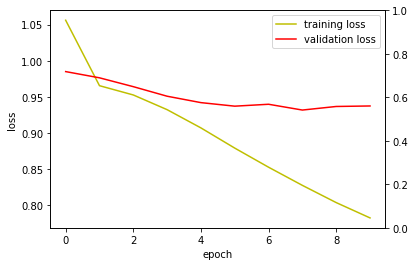

In [27]:
fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label='training loss')
loss_ax.plot(history.history['val_loss'], 'r', label='validation loss')
loss_ax.set_xlabel("epoch")
loss_ax.set_ylabel("loss")
loss_ax.legend(loc="upper right")

plt.show()

## 02. Factorization Machines로 유저 추천 제공
- 유저를 기준으로 Top N개의 영화를 추천하는 시나리오를 구현해봅시다.
- 유저에 해당하는 FM의 variable은 고정으로 두고 영화에 해당하는 variable을 사용해서 여러 개의 영화에 대한 평점을 FM으로 예측합니다.
- 예측 평점을 기준으로 정렬하여 가장 높은 평점을 가진 영화를 추천합니다.

#### 100번 유저 추천 예시

In [28]:
users_df.loc[100]

user_id           101
age                10
gender              M
occupation    student
zip_code        05146
Name: 100, dtype: object

In [29]:
user_series = users_df.loc[100]
user_idx = user_id_map[user_series.user_id]
gender_idx = gender_map[user_series.gender]
age_idx = age_map[user_series.age]

#### 모든 영화에 대해서 FM으로 평점을 예측하기 위해 X를 만들어줍니다.

In [30]:
movie_ids= []
X = []

for _, row in movies_df.iterrows():
    movie_id = row['movie_id']
    movie_ids.append(movie_id)
    
    x = [0] * size_X
    
    # user variable은 같은 값을 사용
    idx = 0
    x[idx + user_idx] = 1
    idx += len(user_id_map)
    
    x[idx + gender_idx] = 1
    idx += len(gender_map)
    
    x[idx + age_idx] = 1
    idx += len(age_map)
    
    movie_idx = movie_id_map[movie_id]
    x[idx + movie_idx] = 1
    idx += len(movie_id_map)
    
    # Genre - multi hot encoding
    x[idx : idx + len(genre_list)] = row[genre_list]
    
    X.append(x)
    
X = np.asarray(X)

In [31]:
X

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [32]:
len(X)

1682

In [33]:
X = tf.convert_to_tensor(X, dtype=tf.float32)

In [34]:
pred_ratings = fm.predict(X)
pred_ratings

array([[3.3002152],
       [3.4691017],
       [2.8578994],
       ...,
       [1.9195111],
       [2.564315 ],
       [2.1613357]], dtype=float32)

In [35]:
user_ratings = [(movie_id, pred_rating[0]) for movie_id, pred_rating in zip(movie_ids, pred_ratings)]
user_ratings

[(1, 3.3002152),
 (2, 3.4691017),
 (3, 2.8578994),
 (4, 3.162324),
 (5, 3.3966196),
 (6, 2.7625103),
 (7, 3.1157963),
 (8, 3.3910093),
 (9, 2.7815716),
 (10, 2.0216174),
 (11, 3.538699),
 (12, 3.737462),
 (13, 2.0716982),
 (14, 3.0010386),
 (15, 3.3149576),
 (16, 2.4076335),
 (17, 3.2090948),
 (18, 2.185165),
 (19, 2.2481701),
 (20, 2.14505),
 (21, 2.6794672),
 (22, 3.930584),
 (23, 2.703823),
 (24, 3.620256),
 (25, 2.5362859),
 (26, 2.9294739),
 (27, 3.3586128),
 (28, 3.6296473),
 (29, 2.7938924),
 (30, 2.8746436),
 (31, 3.6744437),
 (32, 2.8632915),
 (33, 3.5014472),
 (34, 2.6658576),
 (35, 2.2807357),
 (36, 1.7445846),
 (37, 1.7283633),
 (38, 2.6717167),
 (39, 2.978011),
 (40, 1.9581575),
 (41, 2.7074041),
 (42, 3.0080113),
 (43, 2.8233228),
 (44, 2.6574268),
 (45, 2.8042665),
 (46, 2.2270632),
 (47, 2.4116085),
 (48, 3.1719658),
 (49, 2.9506216),
 (50, 4.5763793),
 (51, 3.338631),
 (52, 2.9075077),
 (53, 2.1323419),
 (54, 3.174194),
 (55, 2.9796352),
 (56, 3.7475471),
 (57, 3.07139

### Top 10 추천

In [36]:
n = 10
topn = sorted(user_ratings, key=lambda x: (x[1]), reverse=True)[:10]
topn

[(172, 4.617059),
 (50, 4.5763793),
 (313, 4.570279),
 (181, 4.4608603),
 (174, 4.378035),
 (96, 4.2023444),
 (129, 4.179501),
 (64, 4.0987267),
 (385, 4.097508),
 (117, 4.0971713)]

## 03. Xlearn으로 CTR 예측
- Xlearn에서 제공하는 FM 모델로 CTR을 예측해봅니다.
- 주어진 avazu ctr prediction 데이터를 xlearn에 적합하게 변환합니다.
- 모델의 성능은 분류 성능인 logloss로 평가합니다.

### 광고 데이터 특징
- 유저 식별자가 없습니다. 즉, 개별 유저에 대해서 추천을 진행할 때 유저 아이디를 사용하지 않습니다.
- 대신에 다른 피쳐들이 존재합니다. 이를 유저 피쳐로 볼 수도 있고 컨텍스트 피쳐로 볼 수도 있습니다. 이런 피쳐를 사용하여 클릭률을 예측합니다.
- 다른 데이터와 가장 큰 차이점은 **`유저에게 광고가 노출되었으니 클릭하지 않았다는 Non-click 데이터`**가 존재합니다.
- 기존에는 **`구매했다 혹은 클릭했다는 positive feedback`**만 존재했지만 이 데이터는 positive feedback과 negative feedback이 모두 존재합니다. 

In [37]:
file_path = "../data/avazu-ctr-prediction/ad_click.csv"

In [38]:
parse_date = lambda x: datetime.strptime(x, '%y%m%d%H').strftime("%Y-%m-%d")
click_df = pd.read_csv(file_path, parse_dates = ['datetime'], date_parser = parse_date)
click_df

,id,click,datetime,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,...,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
0,10019071520499579916,0,2014-10-21,1005,0,da79c793,71ed77a0,f028772b,ecad2386,7801e8d9,...,1,0,18993,320,50,2161,0,35,-1,157
1,10025633842336165171,0,2014-10-21,1010,1,85f751fd,c4e18dd6,50e219e0,8c0dcd5a,7801e8d9,...,4,0,21665,320,50,2493,3,35,-1,117
2,10092735447533755726,0,2014-10-21,1002,0,61a8c644,948ff336,50e219e0,ecad2386,7801e8d9,...,0,0,19665,320,50,2253,2,303,-1,52
3,10141326312159899433,1,2014-10-21,1005,1,d9750ee7,98572c79,f028772b,ecad2386,7801e8d9,...,1,0,15706,320,50,1722,0,35,-1,79
4,10141793556467368079,0,2014-10-21,1005,0,543a539e,c7ca3108,3e814130,ecad2386,7801e8d9,...,1,0,20362,320,50,2333,0,39,-1,157
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,9705070284119894086,0,2014-10-30,1005,1,57fe1b20,5b626596,f028772b,ecad2386,7801e8d9,...,1,0,23722,320,50,2716,3,47,-1,23
199996,9907898844680985083,0,2014-10-30,1005,0,85f751fd,c4e18dd6,50e219e0,53de0284,d9b5648e,...,1,0,21706,320,50,2498,3,41,100111,61
199997,9925599241747576355,0,2014-10-30,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,1,0,22676,320,50,2616,0,35,-1,51
199998,9995064718229733761,0,2014-10-30,1002,0,c135a32f,b8393312,50e219e0,ecad2386,7801e8d9,...,0,0,17894,320,50,2039,2,39,100077,32


#### 사용 가능한 피쳐 및 타겟 컬럼 확인

In [39]:
click_df.columns

Index(['id', 'click', 'datetime', 'C1', 'banner_pos', 'site_id', 'site_domain',
       'site_category', 'app_id', 'app_domain', 'app_category', 'device_id',
       'device_ip', 'device_model', 'device_type', 'device_conn_type', 'C14',
       'C15', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21'],
      dtype='object')

#### 데이터의 unique count 확인
- id, device_ip, device_id와 같은 피쳐들은 사용하지 않습니다.

In [40]:
click_df.apply(lambda x: len(x.unique())).sort_values(ascending=False)

id                  200000
device_ip           143725
device_id            33229
device_model          3751
C14                   1934
site_id               1804
app_id                1776
site_domain           1711
C17                    405
C20                    159
app_domain             112
C19                     65
C21                     60
app_category            22
site_category           20
datetime                10
C16                      9
C15                      8
banner_pos               7
C1                       7
device_type              4
device_conn_type         4
C18                      4
click                    2
dtype: int64

#### 클릭 0 / 1 비율

In [41]:
click_df['click'].value_counts() / len(click_df)

0    0.829755
1    0.170245
Name: click, dtype: float64

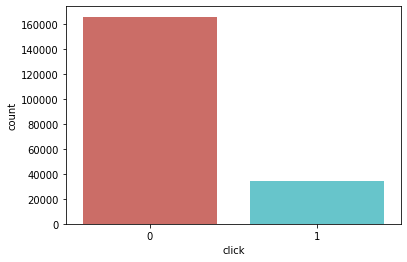

In [42]:
sns.countplot(x='click', data=click_df, palette='hls')
plt.show()

#### 광고 소재(C14)별 CTR 분포

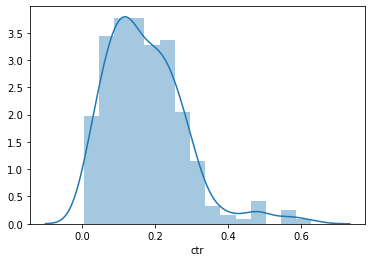

In [43]:
creative_ctr = pd.DataFrame({
    'imp' : click_df.groupby(['C14'])['click'].count(),
    'click' : click_df.groupby(['C14'])['click'].sum()
}).reset_index()

creative_ctr['ctr'] = creative_ctr['click'] / creative_ctr['imp']

# imp 100회 이상인 소재별 ctr 분포
ax = sns.distplot(creative_ctr[creative_ctr['imp'] >= 100]['ctr'])

#### 앱(app_id)별 CTR 분포

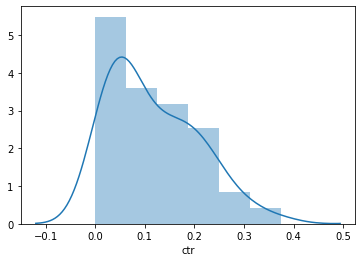

In [44]:
app_ctr = pd.DataFrame({
    'imp': click_df.groupby(['app_id'])['click'].count(),
    'click': click_df.groupby(['app_id'])['click'].sum()
}).reset_index()
app_ctr['ctr'] = app_ctr['click'] / app_ctr['imp']

# imp 100회 이상인 app_id의 ctr 분포
ax = sns.distplot(app_ctr[app_ctr['imp'] >= 100]['ctr'])

### 데이터 전처리

In [45]:
click_df = click_df[[
    'click', 'datetime', 'banner_pos', 'site_id', 'site_domain',
    'site_category', 'app_id', 'app_domain', 'app_category',
    'device_model', 'device_type', 'device_conn_type',
    'C1', 'C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21'
]]

#### FM에 사용할 피쳐들

In [46]:
# FM에 사용할 피쳐들

feature_col = [
    'banner_pos', 'site_id', 'site_domain','site_category', 'app_id', 'app_domain',
    'app_category', 'device_model', 'device_type', 'device_conn_type',
    'C1', 'C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21'
]

for feature in feature_col:
    click_df[feature] = click_df[feature].astype("category")
    click_df[feature] = click_df[feature].cat.codes
    
click_df

,click,datetime,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_model,...,device_conn_type,C1,C14,C15,C16,C17,C18,C19,C20,C21
0,0,2014-10-21,0,1546,767,18,1648,43,0,3696,...,0,2,375,3,2,102,0,2,0,42
1,0,2014-10-21,1,949,1316,5,965,43,3,441,...,0,5,719,3,2,196,3,2,0,39
2,0,2014-10-21,0,706,1001,5,1648,43,0,1676,...,0,1,410,3,2,116,2,21,0,15
3,1,2014-10-21,1,1541,1029,18,1648,43,0,2011,...,0,2,202,3,2,51,0,2,0,22
4,0,2014-10-21,0,617,1338,3,1648,43,0,3004,...,0,2,515,3,2,144,0,4,0,42
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,0,2014-10-30,1,647,604,18,1648,43,0,1272,...,0,2,1771,3,2,378,3,8,0,6
199996,0,2014-10-30,0,949,1316,5,564,91,3,2240,...,0,2,759,3,2,201,3,5,81,16
199997,0,2014-10-30,0,217,1620,1,1648,43,0,235,...,0,2,1272,3,2,294,0,2,0,14
199998,0,2014-10-30,0,1361,1251,5,1648,43,0,121,...,0,1,291,3,2,91,2,4,56,7


#### feature dim size

In [47]:
feature_dim = {}
for feature in feature_col: feature_dim[feature] = click_df[feature].nunique()
feature_dim

{'banner_pos': 7,
 'site_id': 1804,
 'site_domain': 1711,
 'site_category': 20,
 'app_id': 1776,
 'app_domain': 112,
 'app_category': 22,
 'device_model': 3751,
 'device_type': 4,
 'device_conn_type': 4,
 'C1': 7,
 'C14': 1934,
 'C15': 8,
 'C16': 9,
 'C17': 405,
 'C18': 4,
 'C19': 65,
 'C20': 159,
 'C21': 60}

In [48]:
print('number of variables:', sum([dim for dim in feature_dim.values()]))

number of variables: 11862


#### 전체 데이터를 fm의 variable number로 변환

In [49]:
idx = 0
for feature in feature_col:
    click_df[feature] = click_df[feature] + idx
    idx += feature_dim[feature]
    
click_df

,click,datetime,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_model,...,device_conn_type,C1,C14,C15,C16,C17,C18,C19,C20,C21
0,0,2014-10-21,0,1553,2578,3540,5190,5361,5430,9148,...,9207,9213,9593,11155,11162,11271,11574,11580,11643,11844
1,0,2014-10-21,1,956,3127,3527,4507,5361,5433,5893,...,9207,9216,9937,11155,11162,11365,11577,11580,11643,11841
2,0,2014-10-21,0,713,2812,3527,5190,5361,5430,7128,...,9207,9212,9628,11155,11162,11285,11576,11599,11643,11817
3,1,2014-10-21,1,1548,2840,3540,5190,5361,5430,7463,...,9207,9213,9420,11155,11162,11220,11574,11580,11643,11824
4,0,2014-10-21,0,624,3149,3525,5190,5361,5430,8456,...,9207,9213,9733,11155,11162,11313,11574,11582,11643,11844
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,0,2014-10-30,1,654,2415,3540,5190,5361,5430,6724,...,9207,9213,10989,11155,11162,11547,11577,11586,11643,11808
199996,0,2014-10-30,0,956,3127,3527,4106,5409,5433,7692,...,9207,9213,9977,11155,11162,11370,11577,11583,11724,11818
199997,0,2014-10-30,0,224,3431,3523,5190,5361,5430,5687,...,9207,9213,10490,11155,11162,11463,11574,11580,11643,11816
199998,0,2014-10-30,0,1368,3062,3527,5190,5361,5430,5573,...,9207,9212,9509,11155,11162,11260,11576,11582,11699,11809


### train / test 데이터 생성

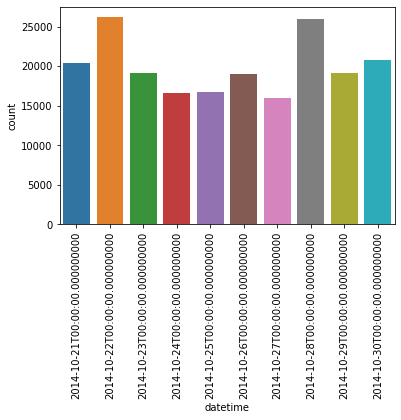

In [50]:
g = sns.countplot(x = 'datetime', data=click_df)
plt.xticks(rotation=90)
plt.show()

#### 날짜를 기준으로 train과 test 데이터를 나눕니다

In [51]:
train_df = click_df[click_df['datetime'] <= '2014-10-28']
test_df = click_df[click_df['datetime'] > '2014-10-28']

In [52]:
print(len(train_df))
print(len(test_df))

160052
39948


#### xlearn의 fm 데이터는 ylabel index_1:value_1 index_2:value_2 ... 로 만들어야 합니다

In [53]:
with open('./fm_train.txt', 'w') as f:
    for _, row in tqdm(train_df.iterrows()):
        label = row['click']
        feature = [str(label)]+ [str(elem) + ':1.0' for elem in row[feature_col].values]
        f.write(' '.join(feature) + '\n')

In [54]:
with open('./fm_test.txt', 'w') as f:
    for _, row in tqdm(test_df.iterrows()):
        label = row['click']
        feature = [str(label)]+ [str(elem) + ':1.0' for elem in row[feature_col].values]
        f.write(' '.join(feature) + '\n')

### xlearn FM
- xlearn의 경우 command line 혹은 python console로 실행할 때 학습 진행 상황 및 training loss, validation loss가 출력됩니다
- jupyte notebook에 코드를 적어놓았지만 실제 실행은 python console에서 진행합니다
- 참고: xlearn 모델 관련 [하이퍼파라미터](https://xlearn-doc.readthedocs.io/en/latest/all_api/index.html?highlight=create_fm#xlearn-python-api)

In [55]:
import xlearn as xl
xl.hello()

#### FM 모델 선언

In [56]:
fm_model = xl.create_fm()
fm_model.setTrain("./fm_train.txt")
fm_model.setValidate("./fm_test.txt")

# 하이퍼 파라미터
param = {"task" : "binary", "lr" : 0.2, "lambda" : 0.002, "k" : 20, "epoch" : 10}

# 모델 학습
fm_model.setTXTModel("./fm_model.txt")
fm_model.fit(param, "./fm_model.out")

#### test 데이터를 사용하여 학습된 FM 모델로 CTR 에측 => output.txt

In [57]:
fm_model.setTest("./fm_test.txt")
fm_model.setSigmoid()
fm_model.predict("./fm_model.out", "./fm_output.txt")

### 하이퍼 파라미터 튜닝

In [58]:
from sklearn.metrics import log_loss

test_click = test_df['click'].values

result = []

for k in [10, 20, 30, 50]:
    for _lambda in [0.001, 0.002, 0.005]:
        for lr in [0.1, 0.2, 0.3]:
            
            # train
            fm_model = xl.create_fm()         
            fm_model.setTrain("./fm_train.txt")
            param = {'task':'binary', 'lr':lr, 'lambda': _lambda, 'k': k, 'epoch': 30}
            fm_model.fit(param, "./fm_model.out")
            
            # test
            fm_model.setTest("./fm_test.txt")
            fm_model.setSigmoid()
            pCTR = fm_model.predict("./fm_model.out")
            result.append([k, _lambda, lr, log_loss(test_click, pCTR)])
            print(k, _lambda, lr, log_loss(test_click, pCTR))
            
result_df = pd.DataFrame(result, columns = ['k', 'lambda', 'lr', 'logloss'])

10 0.001 0.1 0.4031882022139464
10 0.001 0.2 0.4026304071250186
10 0.001 0.3 0.40338115462550683
10 0.002 0.1 0.40353373972914647
10 0.002 0.2 0.4028191917615855
10 0.002 0.3 0.4030937918225485
10 0.005 0.1 0.40514731258598735
10 0.005 0.2 0.4045273561333793
10 0.005 0.3 0.4045239623143722
20 0.001 0.1 0.4031765566805713
20 0.001 0.2 0.40268646533513747
20 0.001 0.3 0.40331467333186755
20 0.002 0.1 0.4036410590281252
20 0.002 0.2 0.4030301474817579
20 0.002 0.3 0.40313613493027395
20 0.005 0.1 0.4051536526573878
20 0.005 0.2 0.40449192316059773
20 0.005 0.3 0.4046535143263909
30 0.001 0.1 0.40323348001851267
30 0.001 0.2 0.40281670918644163
30 0.001 0.3 0.40353748921585725
30 0.002 0.1 0.40358182594408204
30 0.002 0.2 0.40286119695285144
30 0.002 0.3 0.40317944272071504
30 0.005 0.1 0.4051637802508687
30 0.005 0.2 0.4048047524147557
30 0.005 0.3 0.40454210505648386
50 0.001 0.1 0.4030832897661586
50 0.001 0.2 0.40287037176350765
50 0.001 0.3 0.4031574244822324
50 0.002 0.1 0.4035105603

In [59]:
result_df.sort_values(by='logloss')

,k,lambda,lr,logloss
1,10,0.001,0.2,0.402630
10,20,0.001,0.2,0.402686
19,30,0.001,0.2,0.402817
4,10,0.002,0.2,0.402819
22,30,0.002,0.2,0.402861
28,50,0.001,0.2,0.402870
13,20,0.002,0.2,0.403030
27,50,0.001,0.1,0.403083
5,10,0.002,0.3,0.403094
14,20,0.002,0.3,0.403136
